In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

from pyathena import connect
from pyathena.pandas_cursor import PandasCursor

#from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import make_scorer, SCORERS, f1_score, precision_score, recall_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import tensorflow as tf
from tensorflow import keras

import warnings
import time

#warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = 'raise'  # default='warn'
#pd.options.display.max_columns = 30
#pd.options.display.max_rows = 50

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Define connection to DB
conn = connect(
    s3_staging_dir='s3://aws-athena-query-results-323906537337-us-east-1/',
    region_name='us-east-1',
    cursor_class=PandasCursor
    )
cursor = conn.cursor()

# 0 Data

## 0.1 pbp data

In [ ]:
# Note: NCAA football could have many many OT periods

In [2]:
# playtypeid:
# 1 = pass attempt
# 2 = incomplete pass attempt
# 3 = sack
# 4 = designed rush OR scramble
# 9 = intercepted pass attempt

simple_query = f'''
select 
    cast(season as integer) season, 
    eventmetadata.week, eventmetadata.eventid gamecode, eventmetadata.eventtypeid,
    if(teammetadata[1].ishometeam, teammetadata[1].teamid, teammetadata[2].teamid) homeTeam,
    if(teammetadata[2].ishometeam, teammetadata[1].teamid, teammetadata[2].teamid) awayTeam,
    
    pbp.startpossessionteamid offenseTeam,
    if(pbp.startpossessionteamid = teammetadata[1].teamid, teammetadata[2].teamid, teammetadata[1].teamid) defenseTeam,
    
    cast(pbp.playid as integer) playid, pbp.driveid, pbp.period,
    pbp.secondsremaininginperiod,
    
    case 
        when pbp.period in (1,2) then 1
        when pbp.period in (3,4) then 2
        else pbp.period - 2
        end halfGame,
    
    case 
        when pbp.down is null then 0
        else pbp.down
        end down,
        
    case
        when pbp.distance is null then 0.0
        else cast(pbp.distance as double) 
        end yardsToGo,
        
    cast(pbp.startyardsfromgoal as double) yardsFromGoal, 

    pbp.awayscorebefore awayScore, 
    pbp.homescorebefore homeScore,
    pbp.awayscoreafter  awayScoreAfter, 
    pbp.homescoreafter  homeScoreAfter,
    if(teammetadata[1].ishometeam, teammetadata[1].score, teammetadata[2].score) homeFinalScore,
    if(teammetadata[2].ishometeam, teammetadata[1].score, teammetadata[2].score) awayFinalScore,
    
    case
        when teammetadata[1].teamid = pbp.startpossessionteamid and teammetadata[1].ishometeam then pbp.homescorebefore
        when teammetadata[2].teamid = pbp.startpossessionteamid and teammetadata[2].ishometeam then pbp.homescorebefore
        else pbp.awayscorebefore
        end as offenseScore,
    
    pbp.playtype.playtypeid, pbp.playtype.name playName,
    
    case 
        when pbp.playtype.playtypeid = 57 then 1
        else 0
        end offenseTimeout,
        
    case 
        when pbp.playtype.playtypeid = 58 then 1
        else 0
        end defenseTimeout
    
from datalakefootball.pbp
where 
    leagueid='16'
    and season>='2015' --and season<='2019'
    and eventmetadata.eventtypeid in (1,2)
    -- and pbp.period <= 4
    -- and pbp.down is not null -- this will elliminate field goal attempts and a few other actions
    -- and pbp.playtype.playtypeid not in (5,13) -- 2-min warning, kickoff
order by season, eventmetadata.week, eventmetadata.eventid, pbp.period, playid --, secondsremaininginperiod desc
'''

if True:
    pbp_df = cursor.execute(simple_query).as_pandas()
    print(pbp_df.info())
else:
    print("Failed to query!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662259 entries, 0 to 662258
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   season                    662259 non-null  Int64  
 1   week                      662259 non-null  Int64  
 2   gamecode                  662259 non-null  Int64  
 3   eventtypeid               662259 non-null  Int64  
 4   homeTeam                  662259 non-null  Int64  
 5   awayTeam                  662259 non-null  Int64  
 6   offenseTeam               662259 non-null  Int64  
 7   defenseTeam               662259 non-null  Int64  
 8   playid                    662259 non-null  Int64  
 9   driveid                   662259 non-null  Int64  
 10  period                    662259 non-null  Int64  
 11  secondsremaininginperiod  590343 non-null  Int64  
 12  halfGame                  662259 non-null  Int64  
 13  down                      662259 non-null  I

In [3]:
pbp_df.season.unique()

<IntegerArray>
[2015, 2016, 2017, 2018]
Length: 4, dtype: Int64

In [4]:
# Fill in missing game time for regular period

gd = pbp_df.groupby(['gamecode','period'])

pbp_df.secondsremaininginperiod = gd['secondsremaininginperiod'].fillna(method='ffill')

gd = pbp_df.groupby(['gamecode','period'])

pbp_df.secondsremaininginperiod = gd['secondsremaininginperiod'].fillna(method='bfill')

pbp_df['remainingGameTime'] = pbp_df.secondsremaininginperiod + (4 - pbp_df.period).clip(0,) * 900

# overtime the clock is off, we may artificially assign a value of 1 min
id = (pbp_df.secondsremaininginperiod.isnull()) & (pbp_df.period > 4)
pbp_df.loc[id, 'secondsremaininginperiod'] = 120
pbp_df.loc[id, 'remainingGameTime'] = 120

In [5]:
# calculate scoreDiff

pbp_df['scoreDiff'] = pbp_df.homeScore - pbp_df.awayScore
pbp_df.loc[pbp_df.offenseTeam==pbp_df.awayTeam, 'scoreDiff'] = pbp_df.awayScore - pbp_df.homeScore
pbp_df.scoreDiff = pbp_df.scoreDiff.astype('float64') #important for num features

pbp_df['scoreDiffAfter'] = pbp_df.homeScoreAfter - pbp_df.awayScoreAfter
pbp_df.loc[pbp_df.offenseTeam==pbp_df.awayTeam, 'scoreDiffAfter'] = pbp_df.awayScoreAfter - pbp_df.homeScoreAfter
pbp_df.scoreDiffAfter = pbp_df.scoreDiffAfter.astype('float64') #important for num features

pbp_df['adjScoreDiff'] = pbp_df.scoreDiff / np.power(pbp_df.remainingGameTime+1, 0.5)

In [6]:
# calculate remaining TO, no sure if this works for CFB
# > calculate timeout used in each half game

pbp_df[['homeTO','awayTO','remainingHomeTOs','remainingHomeTOs']] = 0

id = ((pbp_df.offenseTimeout == 1) & (pbp_df.offenseTeam == pbp_df.homeTeam)) | \
        ((pbp_df.defenseTimeout == 1) & (pbp_df.defenseTeam == pbp_df.homeTeam))
pbp_df.loc[id, 'homeTO'] = 1

id = ((pbp_df.offenseTimeout == 1) & (pbp_df.offenseTeam == pbp_df.awayTeam)) | \
        ((pbp_df.defenseTimeout == 1) & (pbp_df.defenseTeam == pbp_df.awayTeam))
pbp_df.loc[id, 'awayTO'] = 1

gd = pbp_df.groupby(['gamecode','halfGame'])

pbp_df[['remainingHomeTOs','remainingAwayTOs']] = gd[['homeTO','awayTO']].cumsum()
pbp_df[['remainingHomeTOs','remainingAwayTOs']] = gd[['homeTO','awayTO']].cumsum()


id = pbp_df.period <= 4
pbp_df.loc[id, ['remainingHomeTOs','remainingAwayTOs']] = 3 - pbp_df[['remainingHomeTOs','remainingAwayTOs']]
pbp_df.loc[~id, ['remainingHomeTOs','remainingAwayTOs']] = 1 -  pbp_df[['remainingHomeTOs','remainingAwayTOs']]


pbp_df[['remainingOffenseTOs','remainingDefenseTOs']] = pbp_df[['remainingHomeTOs','remainingAwayTOs']].copy()

id = (pbp_df.offenseTeam == pbp_df.awayTeam)

pbp_df.loc[id, 'remainingOffenseTOs'] = pbp_df.loc[id, 'remainingAwayTOs'].values.astype('float64')
pbp_df.loc[id, 'remainingDefenseTOs'] = pbp_df.loc[id, 'remainingHomeTOs'].values.astype('float64')

pbp_df.loc[pbp_df.remainingOffenseTOs < 0, 'remainingOffenseTOs'] = 0
pbp_df.loc[pbp_df.remainingDefenseTOs < 0, 'remainingDefenseTOs'] = 0

In [7]:
# ceate known playtype pre-play

pbp_df['playDesign'] = 0 # unknown play
pbp_df.loc[pbp_df.playtypeid.isin([22]), 'playDesign'] = 1 # extra point
pbp_df.loc[pbp_df.playtypeid.isin([52,53,54,55,56]), 'playDesign'] = 2 # 2-point attempt
pbp_df.loc[pbp_df.playtypeid.isin([42,35,36]), 'playDesign'] = 3 # field goal attempt

,gamecode,period,driveid,offenseTeam,scoreDiffAfter,driveScoreDiffChange,driveOutcome
0,1522535,1,1,3442,0.0,0.0,0
1,1522535,1,1,3478,0.0,0.0,0
2,1522535,1,2,3442,0.0,0.0,0
3,1522535,1,3,3478,7.0,7.0,5
4,1522535,1,4,3478,7.0,0.0,0


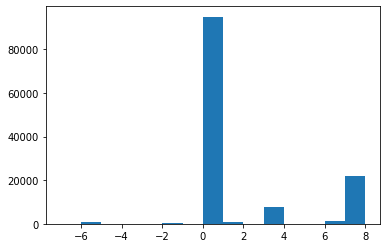

In [8]:
# calculate outcome for each drive - applied for over-time model
eScoreDiff = pbp_df.groupby(['gamecode','driveid','offenseTeam'])[['gamecode','period','driveid','offenseTeam','scoreDiffAfter']].tail(1).\
                reset_index(drop=True)
sScoreDiff = pbp_df.groupby(['gamecode','driveid','offenseTeam'])[['gamecode','driveid','offenseTeam','scoreDiff']].head(1).reset_index(drop=True)

eScoreDiff['driveScoreDiffChange'] = (eScoreDiff.scoreDiffAfter - sScoreDiff.scoreDiff)
eScoreDiff['driveOutcome'] = 0  # no-score
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==1, 'driveOutcome'] = 1  # FG
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==2, 'driveOutcome'] = 2  # FG
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==3, 'driveOutcome'] = 3  # FG
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==6, 'driveOutcome'] = 4  # TD w.o. extra point
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==7, 'driveOutcome'] = 5  # TD w extra point
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==8, 'driveOutcome'] = 6  # TD w extra point
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==-2, 'driveOutcome'] = 7 # defense points from offense turn-over
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==-6, 'driveOutcome'] = 8 # defense points from offense turn-over

plt.hist(eScoreDiff.driveScoreDiffChange, bins=range(-7,9))
eScoreDiff.head()

              gamecode  period  driveid  offenseTeam  scoreDiffAfter  \
driveOutcome                                                           
0                96165   96165    96165        96165           96165   
1                  847     847      847          847             847   
2                   36      36       36           36              36   
3                 7484    7484     7484         7484            7484   
4                 1348    1348     1348         1348            1348   
5                21443   21443    21443        21443           21443   
6                  431     431      431          431             431   
7                  248     248      248          248             248   
8                  819     819      819          819             819   

              driveScoreDiffChange  
driveOutcome                        
0                            96165  
1                              847  
2                               36  
3                     

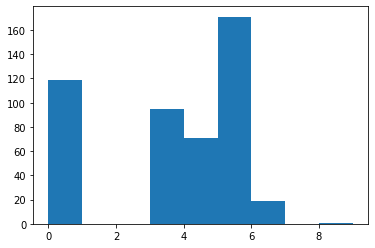

In [9]:
# drive-outcome between regular time and overtime
id = eScoreDiff.period > 4
plt.hist(eScoreDiff.driveOutcome[id], bins=range(0, 10))
print(eScoreDiff[~id].groupby('driveOutcome').count())
print(eScoreDiff[id].groupby('driveOutcome').count())

In [10]:
pbp_df = pd.merge(pbp_df, eScoreDiff[['gamecode','driveid','offenseTeam','driveScoreDiffChange','driveOutcome']], on=['gamecode','driveid','offenseTeam'])
sScoreDiff.rename(columns={'scoreDiff':'driveStartScoreDiff'}, inplace=True)
pbp_df = pd.merge(pbp_df, sScoreDiff[['gamecode','driveid','offenseTeam','driveStartScoreDiff']], on=['gamecode','driveid','offenseTeam'])

In [11]:
# period start offense team: for OT modeling
gb = pbp_df.groupby(['gamecode','period']).head(1)[['gamecode','period','offenseTeam']]
gb.rename(columns={'offenseTeam':'period_start_offense_team'}, inplace=True)
pbp_df = pd.merge(pbp_df, gb, on=['gamecode','period'], how='left')

In [12]:
# NCAA not allowing for tie
id = (pbp_df.homeTeam==pbp_df.offenseTeam) & (pbp_df.homeFinalScore>pbp_df.awayFinalScore)
id = id | ((pbp_df.awayTeam==pbp_df.offenseTeam) & (pbp_df.homeFinalScore<pbp_df.awayFinalScore))

pbp_df['offenseWin'] = id.astype('bool')

In [16]:
pbp_df.driveOutcome.describe()

count    662259.000000
mean          1.895357
std           2.297549
min           0.000000
25%           0.000000
50%           0.000000
75%           5.000000
max           8.000000
Name: driveOutcome, dtype: float64

## 0.2 pre-game odds

In [ ]:
pbp_df['offenseFavoritePoints'] = 0.0

# 1 Features / label creation

## 1.1 Features / label for drive outcome

In [19]:
num_fields_drive = [
                'scoreDiff',
                'adjScoreDiff', 
                'secondsremaininginperiod',
                'remainingGameTime',
                'yardsToGo',
                'yardsFromGoal',
                #'offenseFavoritePoints', # place holder
                'offenseScore',
                'remainingOffenseTOs',
                'remainingDefenseTOs',
             ]

cat_fields_drive = [
                'eventtypeid',
                 'period',
                 'down',
                 'playDesign'
             ]

## (1) regular time

In [27]:
id_train = (pbp_df.season < 2018)  #& (pbp_df.period <= 4) #| (win_df.week < 22)) 
id_test  = (pbp_df.season == 2018) #& (pbp_df.period <= 4) # & (~win_df['winProbability.before'].isnull())

# None-StandardScaler version
transform_pipeline_drive = ColumnTransformer(transformers=[
                                            ('num', 'passthrough', num_fields_drive),
                                            ('cat', OneHotEncoder(categories='auto'), cat_fields_drive)
                                        ])

features_train_drive = transform_pipeline_drive.fit_transform(pbp_df[id_train])
features_test_drive  = transform_pipeline_drive.transform(pbp_df[id_test])

feature_names_drive = num_fields_drive.copy()
cat_one_hot_fields = list(transform_pipeline_drive.named_transformers_.cat.get_feature_names(input_features=cat_fields_drive))
feature_names_drive.extend(cat_one_hot_fields)

print(features_train_drive.shape, features_test_drive.shape)

(501545, 31) (160714, 31)


In [28]:
# classification label for the whole game
label_train_drive = pbp_df.driveOutcome[id_train]
label_test_drive  = pbp_df.driveOutcome[id_test]

In [ ]:
model_RFC_drive = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_leaf=20, random_state=42)
model_RFC_drive.fit(features_train_drive, label_train_drive) # features is from section 1.0
#pred_d = model_RFC_drive.predict_proba(features)

In [ ]:
# feature importance study
feature_score = pd.DataFrame([feature_names_drive, model_RFC_drive.feature_importances_], index=['feature','importance']).transpose()
feature_score.sort_values(by='importance', ascending=False)

In [ ]:
# use drive outcome model to create new features 
# calculate expected score

features_drive = transform_pipeline_drive.transform(pbp_df)

if type(features_drive) == np.ndarray:
    features_drive = pd.DataFrame(features_drive, columns=feature_names_drive, dtype=np.float)
else:
    features_drive = pd.DataFrame(features_drive.toarray(), columns=feature_names_drive, dtype=np.float)

pred_d = model_RFC_drive.predict_proba(features_drive)

pbp_df['expectedDriveScore'] = np.dot(pred_d, np.array([0,1,2,3,6,7,8,-2,-6]))
pbp_df['expectedScoreDiff'] = pbp_df.driveStartScoreDiff + pbp_df.expectedDriveScore
pbp_df['adjExpectedScoreDiff'] = pbp_df.expectedScoreDiff / np.power(pbp_df.remainingGameTime+1, 0.5)

pbp_df['expectedExtraScore'] = pbp_df.driveStartScoreDiff - ( pbp_df.expectedDriveScore - pbp_df.scoreDiff)

## (2) overtime 

In [20]:
# the features and label for overtime basically relies on drive outcome model!
#
# Due to limited data, no train/test split

# None-StandardScaler version
transform_pipeline_drive_o = ColumnTransformer(transformers=[
                                            ('num', 'passthrough', num_fields_drive),
                                            ('cat', OneHotEncoder(categories='auto'), cat_fields_drive)
                                        ])

id = (pbp_df.period>=5)
features_drive_o  = transform_pipeline_drive_o.fit_transform(pbp_df[id])

feature_names_drive_o = num_fields_drive.copy()
cat_one_hot_fields = list(transform_pipeline_drive_o.named_transformers_.cat.get_feature_names(input_features=cat_fields_drive))
feature_names_drive_o.extend(cat_one_hot_fields)

if type(features_drive_o) == np.ndarray:
    features_drive_o = pd.DataFrame(features_drive_o, columns=feature_names_drive_o, dtype=np.float)
else:
    features_drive_o = pd.DataFrame(features_drive_o.toarray(), columns=feature_names_drive_o, dtype=np.float)

label_drive_o = pbp_df.driveOutcome[id]

## 1.2 Features / label for regular time game outcome

In [ ]:
id_train = (pbp_df.season < 2018) & (pbp_df.period <= 4) #| (win_df.week < 22)) 
id_test  = (pbp_df.season == 2018) & (pbp_df.period <= 4) # & (~win_df['winProbability.before'].isnull())
id_championship = (pbp_df.gamecode == 1984143) & (pbp_df.period <= 4)

num_fields = [
                'scoreDiff',
                'expectedExtraScore',
                #'adjScoreDiff',
                #'expectedScoreDiff',
                #'expectedAdjScoreDiff',
                #'expectedDriveScoreDiff',
                #'driveStartScoreDiff',
                #'expectedDriveScore',
                'adjExpectedScoreDiff', 
                'secondsremaininginperiod',
                'remainingGameTime',
                'yardsToGo',
                'yardsFromGoal',
                #'offenseFavoritePoints', #place holder
                'offenseScore',
                'remainingOffenseTOs',
                'remainingDefenseTOs',
             ]

cat_fields = [
                'eventtypeid',
                 'period',
                 'down',
                 'playDesign'
             ] 

# None-StandardScaler version
transform_pipeline = ColumnTransformer(transformers=[
                                            ('num', 'passthrough', num_fields),
                                            ('cat', OneHotEncoder(categories='auto'), cat_fields)
                                        ])
features_train = transform_pipeline.fit_transform(pbp_df[id_train])
features_test  = transform_pipeline.transform(pbp_df[id_test])
features_champion  = transform_pipeline.transform(pbp_df[id_champion])

feature_names = num_fields.copy()
cat_one_hot_fields = list(transform_pipeline.named_transformers_.cat.get_feature_names(input_features=cat_fields))
feature_names.extend(cat_one_hot_fields)
cat_one_hot_fields

if type(features_train) == np.ndarray:
    features_train = pd.DataFrame(features_train, columns=feature_names, dtype=np.float)
    features_test  = pd.DataFrame(features_test,  columns=feature_names, dtype=np.float)
    features_champion  = pd.DataFrame(features_champion,  columns=feature_names, dtype=np.float)
else:
    features_train = pd.DataFrame(features_train.toarray(), columns=feature_names, dtype=np.float)
    features_test  = pd.DataFrame(features_test.toarray(),  columns=feature_names, dtype=np.float)
    features_champion  = pd.DataFrame(features_champion.toarray(),  columns=feature_names, dtype=np.float)

print(features_train.shape, features_test.shape, features_champion.shape)

In [ ]:
# classification label for the whole game
label_train = pbp_df.offenseWin[id_train]
label_test  = pbp_df.offenseWin[id_test]
label_champion  = pbp_df.offenseWin[id_championship]

# 2 Model Study

## 2.1 Regular time win-prob model

In [29]:
# instantiate models
folds = 5

model_logistic = LogisticRegression(solver='lbfgs', fit_intercept=True, max_iter=10000, tol=1e-4, random_state=42)

# depth of 10 seems better than 15
model_RFC = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10, random_state=42)

model_SGD = SGDClassifier(loss='log', penalty=None, fit_intercept=True, max_iter=10000, tol=1e-4, random_state=42)

model_SVC = LinearSVC(max_iter=10000, tol=1e-4, random_state=42)

model_RFR = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=10, random_state=42)

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_DL_model():
    model_DL = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[25,]),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(250, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(150, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(80, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(30, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # multi-nomial classification
    #model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['AUC'])

    # binary classification
    optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)
    model_DL.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[['accuracy', 'AUC']])

    #model_DL.summary()
    
    return model_DL

model_DL = KerasClassifier(build_fn=create_DL_model, epochs=20, verbose=1)

In [ ]:
def create_DL_2_model():
    input_ = keras.layers.Input(shape=features_train_drive.shape[1:], name='input')
    input_a = keras.layers.Input(shape=features_train_drive.shape[1:], name='input_a')

    hidden_1 = keras.layers.BatchNormalization()(input_)

    hidden_a1 = keras.layers.BatchNormalization()(input_a)
    hidden_a2 = keras.layers.Dense(100, activation='elu', kernel_initializer="he_normal")(hidden_a1)
    hidden_a3 = keras.layers.BatchNormalization()(hidden_a2)
    hidden_a4 = keras.layers.Dense(20, activation='elu', kernel_initializer="he_normal")(hidden_a3)
    hidden_a5 = keras.layers.BatchNormalization()(hidden_a4)

    aux_output = keras.layers.Dense(9, name='aux_output', activation='softmax')(hidden_a5)

    concat = keras.layers.concatenate([hidden_1, aux_output])


    hidden_2 = keras.layers.Dense(250, activation='elu', kernel_initializer="he_normal")(concat)
    hidden_3 = keras.layers.BatchNormalization()(hidden_2)

    hidden_4 = keras.layers.Dense(150, activation='elu', kernel_initializer="he_normal")(hidden_3)
    hidden_5 = keras.layers.BatchNormalization()(hidden_4)

    hidden_6 = keras.layers.Dense(80, activation='elu', kernel_initializer="he_normal")(hidden_5)
    hidden_7 = keras.layers.BatchNormalization()(hidden_6)

    hidden_8 = keras.layers.Dense(80, activation='elu', kernel_initializer="he_normal")(hidden_7)
    hidden_9 = keras.layers.BatchNormalization()(hidden_8)

    #concat = keras.layers.concatenate([hidden_7, aux_output])

    output = keras.layers.Dense(1, name='main_output', activation='sigmoid')(hidden_9)

    model_DL_2 = keras.Model(inputs=[input_, input_a], outputs=[output, aux_output])

    optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)
    model_DL_2.compile(loss=['binary_crossentropy','sparse_categorical_crossentropy'], loss_weights=[0.90, 0.10], 
                    optimizer=optimizer, metrics=[['accuracy'],['accuracy']])

    return model_DL_2

model_DL_2 = KerasClassifier(build_fn=create_DL_2_model, epochs=70, verbose=1)

In [ ]:
# Logistic regression model

scores_logistic = cross_validate(model_logistic,
    features_train,
    label_train,
    cv=folds,
    scoring=(['recall','precision','f1','roc_auc']))
print('Pass - Linear logistic regression (P/R/F1/ROC): {:.1%}  {:.1%}  {:.1%} {:.1%}'.format(scores_logistic['test_recall'].mean(), 
                                                                                   scores_logistic['test_precision'].mean(), 
                                                                                   scores_logistic['test_f1'].mean(),
                                                                                  scores_logistic['test_roc_auc'].mean()))

In [30]:
# Random forest classification

scores_RFC = cross_validate(model_RFC,
    features_train,
    label_train,
    cv=folds,
    scoring=(['recall','precision','f1','roc_auc']))
print('Win Probability - Random Forest Classifier (P/R/F1/ROC): {:.2%}  {:.2%}  {:.2%} {:.2%}'.format(scores_RFC['test_recall'].mean(), 
                                                                                scores_RFC['test_precision'].mean(), 
                                                                                scores_RFC['test_f1'].mean(),
                                                                                scores_RFC['test_roc_auc'].mean()))

NameError: name 'features_train' is not defined

In [ ]:
# Deep learning classification

scores_DL = cross_validate(model_DL,
    features_train,
    label_train,
    cv=folds,
    scoring=(['recall','precision','f1','roc_auc']))
print('Win Probability - Random Forest Classifier (P/R/F1/ROC): {:.2%}  {:.2%}  {:.2%} {:.2%}'.format(scores_DL['test_recall'].mean(), 
                                                                                scores_DL['test_precision'].mean(), 
                                                                                scores_DL['test_f1'].mean(),
                                                                                scores_DL['test_roc_auc'].mean()))

In [ ]:
# Deep learning classification

scores_DL2 = cross_validate(model_DL_2,
    features_train,
    label_train,
    cv=folds,
    scoring=(['recall','precision','f1','roc_auc']))
print('Win Probability - Random Forest Classifier (P/R/F1/ROC): {:.2%}  {:.2%}  {:.2%} {:.2%}'.format(scores_DL2['test_recall'].mean(), 
                                                                                scores_DL2['test_precision'].mean(), 
                                                                                scores_DL2['test_f1'].mean(),
                                                                                scores_DL2['test_roc_auc'].mean()))

In [ ]:
# feature importance study
model_RFC.fit(features_train, label_train)
feature_score = pd.DataFrame([feature_names, model_RFC.feature_importances_], index=['feature','importance']).transpose()
feature_score.sort_values(by='importance', ascending=False)

## 2.2 drive outcome model -  regular time

In [31]:
# instantiate models
folds = 5

model_RFC_d = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=10, random_state=42)

model_logistic_d = OneVsRestClassifier(LogisticRegression(solver='lbfgs', fit_intercept=True, max_iter=5000, tol=1e-3, random_state=42))

In [33]:
model_RFC_d.fit(features_train_drive, label_train_drive)
train_probs = pd.DataFrame(model_RFC_d.predict_proba(features_train_drive))
roc_auc_score(label_train_drive, train_probs, multi_class='ovr')

0.906806898382756

In [41]:
label_train_drive.describe()
pbp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662259 entries, 0 to 662258
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   season                     662259 non-null  Int64  
 1   week                       662259 non-null  Int64  
 2   gamecode                   662259 non-null  Int64  
 3   eventtypeid                662259 non-null  Int64  
 4   homeTeam                   662259 non-null  Int64  
 5   awayTeam                   662259 non-null  Int64  
 6   offenseTeam                662259 non-null  Int64  
 7   defenseTeam                662259 non-null  Int64  
 8   playid                     662259 non-null  Int64  
 9   driveid                    662259 non-null  Int64  
 10  period                     662259 non-null  Int64  
 11  secondsremaininginperiod   662259 non-null  Int64  
 12  halfGame                   662259 non-null  Int64  
 13  down                       66

In [ ]:
# Logistic regression model

scores_logistic_d = cross_validate(model_logistic_d,
    features_train_drive,
    label_train_drive, 
    cv=folds,
    scoring=(['recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted']))
print('Drive outcome - logistic regression Classifier (P/R/F1/ROC): {:.1%}  {:.1%}  {:.1%} {:.1%}'.format(scores_logistic_d['test_recall_micro'].mean(), 
                                                                                scores_logistic_d['test_precision_micro'].mean(), 
                                                                                scores_logistic_d['test_f1_micro'].mean(),
                                                                                scores_logistic_d['test_roc_auc_ovr_weighted'].mean()))

In [32]:
# Random forest classification

scores_RFC_d = cross_validate(model_RFC_d,
    features_train_drive,
    label_train_drive,
    cv=folds,
    scoring=(['recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted']))
print('Drive outcome - Random Forest Classifier (P/R/F1/ROC): {:.1%}  {:.1%}  {:.1%} {:.1%}'.format(scores_RFC_d['test_recall_micro'].mean(), 
                                                                                scores_RFC_d['test_precision_micro'].mean(), 
                                                                                scores_RFC_d['test_f1_micro'].mean(),
                                                                                scores_RFC_d['test_roc_auc_ovr_weighted'].mean()))
#sorted(SCORERS.keys()) 

Drive outcome - Random Forest Classifier (P/R/F1/ROC): 68.0%  68.0%  68.0% 81.2%


In [ ]:
# feature importance study
model_RFC_d.fit(features_train_drive, label_train_drive)
feature_score = pd.DataFrame([feature_names_drive, model_RFC_d.feature_importances_], index=['feature','importance']).transpose()
feature_score.sort_values(by='importance', ascending=False)

## 2.3 drive outcome model - overtime

In [24]:
# instantiate models
folds = 4

model_RFC_d_o = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10, random_state=42)

model_logistic_d_o = OneVsRestClassifier(LogisticRegression(solver='lbfgs', fit_intercept=True, max_iter=5000, tol=1e-3, random_state=42))

In [26]:
scores_logistic_d_o = cross_validate(model_logistic_d,
    features_drive_o,
    label_drive_o, 
    cv=folds,
    scoring=(['recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted']))
print('Drive outcome - logistic regression Classifier (P/R/F1/ROC): {:.1%}  {:.1%}  {:.1%} {:.1%}'.format(scores_logistic_d_o['test_recall_micro'].mean(), 
                                                                                scores_logistic_d_o['test_precision_micro'].mean(), 
                                                                                scores_logistic_d_o['test_f1_micro'].mean(),
                                                                                scores_logistic_d_o['test_roc_auc_ovr_weighted'].mean()))

Drive outcome - logistic regression Classifier (P/R/F1/ROC): 48.0%  48.0%  48.0% 75.5%


In [25]:
# Random forest classification

scores_RFC_d_o = cross_validate(model_RFC_d_o,
    features_drive_o,
    label_drive_o,
    cv=folds,
    scoring=(['recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted']))
print('Overtime drive outcome - Random Forest Classifier (P/R/F1/ROC): {:.1%}  {:.1%}  {:.1%} {:.1%}'.format(scores_RFC_d_o['test_recall_micro'].mean(), 
                                                                                scores_RFC_d_o['test_precision_micro'].mean(), 
                                                                                scores_RFC_d_o['test_f1_micro'].mean(),
                                                                                scores_RFC_d_o['test_roc_auc_ovr_weighted'].mean()))
#sorted(SCORERS.keys()) 

Overtime drive outcome - Random Forest Classifier (P/R/F1/ROC): 51.8%  51.8%  51.8% 79.6%


# 3 Model Prediction

## 3.1 Regular time model

### 3.1.1 ML model

In [ ]:
model_RFC.fit(features_train, label_train)

In [ ]:
pred_p = model_RFC.predict_proba(features_train)[:,1]
pred = model_RFC.predict(features_train)
print(roc_auc_score(label_train, pred_p) )

pred_p = model_RFC.predict_proba(features_test)[:,1]
pred = model_RFC.predict(features_test)
print(roc_auc_score(label_test, pred_p) )

In [ ]:
print(f'mse: {mean_squared_error(label_test, pred_p):.3}')#' {mean_squared_error(label_test, legacy_prob):.3}')
print(f'mae: {mean_absolute_error(label_test, pred_p):.3}')# {mean_absolute_error(label_test, legacy_prob):.3}')
print(f"roc_auc: {roc_auc_score(label_test, pred_p):.3}") # \{roc_auc_score(label_test, legacy_prob):.3}")
print(f"accuracy: {accuracy_score(label_test, pred):.3}")# {accuracy_score(label_test, legacy_prob>0.5):.3}")
print(f"precision: {precision_score(label_test, pred):.3}")# {precision_score(label_test, legacy_prob>0.5):.3}")
print(f"recall: {recall_score(label_test, pred):.3}")# {recall_score(label_test, legacy_prob>0.5):.3}")
print(f"f1: {f1_score(label_test, pred):.3}")# {f1_score(label_test, legacy_prob>0.5):.3}")

In [ ]:
# plot one game prediciton results, bowl game of 2017!

### 3.1.2 DL model

In [ ]:
#model_DL = KerasClassifier(build_fn=create_DL_model, epochs=70, verbose=1)
model_DL=create_DL_model()

history = model_DL.fit(features_train, label_train, epochs=70, validation_data=(features_test, label_test) )

In [ ]:
pred_p = model_DL.predict_proba(features_train)
pred   = model_DL.predict_classes(features_train)
print(roc_auc_score(label_train, pred_p) )

pred_p = model_DL.predict_proba(features_test)
pred   = model_DL.predict_classes(features_test)
print(roc_auc_score(label_test, pred_p) )

In [ ]:
print(f'mse: {mean_squared_error(label_test, pred_p):.3}')#' {mean_squared_error(label_test, legacy_prob):.3}')
print(f'mae: {mean_absolute_error(label_test, pred_p):.3}')# {mean_absolute_error(label_test, legacy_prob):.3}')
print(f"roc_auc: {roc_auc_score(label_test, pred_p):.3}") # \{roc_auc_score(label_test, legacy_prob):.3}")
print(f"accuracy: {accuracy_score(label_test, pred):.3}")# {accuracy_score(label_test, legacy_prob>0.5):.3}")
print(f"precision: {precision_score(label_test, pred):.3}")# {precision_score(label_test, legacy_prob>0.5):.3}")
print(f"recall: {recall_score(label_test, pred):.3}")# {recall_score(label_test, legacy_prob>0.5):.3}")
print(f"f1: {f1_score(label_test, pred):.3}")# {f1_score(label_test, legacy_prob>0.5):.3}")

## 3.2 Overtime model

In [ ]:
# function to simulate outcomes of OT
#
# input: features for each play of one game, starting offense team id, starting defense team id, driveOutcomes
# team_1: home_team, team_2: away_team

def OvertimeWinProbabilityCalculation_CFB(features, model_drive, drive_outcomes):
       
    samples = 1000
    
    winProb = []

    for index,row in features.iterrows():
        
        offense_team = row.offense_team
        defense_team = row.defense_team
        start_team = row.start_team
        home_team = row.home_team
        start_score_diff = row.start_score_diff
        row.drop(['offense_team','start_team', 'home_team','defense_team','start_score_diff'], inplace=True)
        
        play_2_probs = createDriveOutcomeDistributionsAtSwitch(row, model_drive)
        
        start_time = time.time()
        
        team_1_wins = 0
        team_1_score = 0
        team_2_score = 0
        
        if (offense_team == start_team): 
            x = np.array(row).reshape(1,-1)
            play_1_prob = model_drive.predict_proba(x)[0, :]

            for i in range(samples):
                re = simulatedOutcome_1(home_team, offense_team, defense_team, team_1_score, team_2_score, model_drive, 
                                        play_1_prob, play_2_probs, drive_outcomes)
                
                if re[0]:
                    team_1_wins += 1
                elif re[1] == re[2]:
                    team_1_wins += 0.5
                    
        else:
            
            if offense_team == home_team:
                team_1_score = start_score_diff
            else:
                team_2_score = start_score_diff
            
            # play_2_prob now needs to be conditional on current score difference!
            x = np.array(row).reshape(1,-1)
            play_2_prob = model_drive.predict_proba(x)[0, :]
            
            for i in range(samples):
                re = simulatedOutcome_2(home_team, offense_team, team_1_score, team_2_score, model_drive, play_2_prob, drive_outcomes)
                
                if re[0]:
                    team_1_wins += 1
                elif re[1] == re[2] :
                    team_1_wins += 0.5
            
        # This part is to address 2-point conversion after certain periods past in OT

        
        wp = np.sum(team_1_wins) / float(samples)
        
        #print(f"--- {(time.time() - start_time)} seconds, {wp} ---") 
        #print('final:', team_1_wins, samples)
        winProb.append( wp )
      
    return winProb

In [ ]:
def createDriveOutcomeDistributionsAtSwitch(feature, model_drive):
    probs = {}
    for score_diff in (-8,-7,-6,-3, 0):
        # create a basic starting play for team 2
        feature_2 = feature.copy()
        
        feature_2.scoreDiff = score_diff
        feature_2.offenseScore = feature_2.offenseScore + score_diff
        feature_2.adjScoreDiff = feature_2.scoreDiff / np.power(feature_2.remainingGameTime+1, 0.5)
        feature_2.yardsToGo = 10
        feature_2.yardsFromGoal = 25
        #feature_2.offenseFavoritePoints = -feature.offenseFavoritePoints
        feature_2.remainingOffenseTOs = feature.remainingDefenseTOs    #This feature is difficult to predict by the end of 1st play, unless we skip it! 
        feature_2.remainingDefenseTOs = feature.remainingOffenseTOs
        feature_2['down_0'] = 0
        feature_2['down_1'] = 1
        feature_2['down_2'] = 0
        feature_2['down_3'] = 0
        feature_2['down_4'] = 0
        feature_2['playDesign_0'] = 1
        feature_2['playDesign_1'] = 0
        feature_2['playDesign_2'] = 0
        feature_2['playDesign_3'] = 0
        
        x = np.array(feature_2).reshape(1,-1)
        play_2_prob = model_drive.predict_proba(x)[0, :]
        probs[score_diff] = play_2_prob
    
    return probs

def updateTeamScoreByDriveOutcome(re, home_team, offense_team, home_team_score, away_team_score):
    if re in (3,):  # field goal
        if home_team == offense_team:
            home_team_score = home_team_score + 3
        else:
            away_team_score = away_team_score + 3
    elif re in [4]:  # touch-down
        if home_team == offense_team:
            home_team_score = home_team_score + 6
        else:
            away_team_score = away_team_score + 6
    elif re in [5]:  # touch-down
        if home_team == offense_team:
            home_team_score = home_team_score + 7
        else:
            away_team_score = away_team_score + 7
    elif re in [6]:  # touch-down
        if home_team == offense_team:
            home_team_score = home_team_score + 8
        else:
            away_team_score = away_team_score + 8
    elif re != 0:
        print("Warning: un-tracked drive-outcome ", re)

    return (home_team_score, away_team_score)

In [ ]:
# this is for team 1

def simulatedOutcome_1(home_team, offense_team, defense_team, team_1_score, team_2_score, model_drive, 
                       play_1_prob, play_2_probs, drive_outcomes):
    
    re = np.random.multinomial(n=1, pvals=play_1_prob) # This should just be the index of available action
    re = drive_outcomes[ np.where(re)[0][0] ]
    
    if re in [1,2,7,8]: # safety or defense TD

        if home_team == offense_team:
            team_2_score += 2
            #print('team 1 turn over lose!')
            return (False, team_1_score, team_2_score)
        else:
            team_1_score += 2
            #print('team 2 turn over lose!')
            return (True, team_1_score, team_2_score)
    else:
        team_1_score, team_2_score = updateTeamScoreByDriveOutcome(re, home_team, offense_team,
                                                                                  team_1_score, team_2_score)
        
        if home_team == offense_team:
            scoreDiff = team_2_score - team_1_score
        else:
            scoreDiff = team_1_score - team_2_score
            
        play_2_prob = play_2_probs[scoreDiff]

        return simulatedOutcome_2(home_team, defense_team, team_1_score, team_2_score, model_drive, play_2_prob, drive_outcomes)

In [ ]:
# this is for team 2

def simulatedOutcome_2(home_team, offense_team, team_1_score, team_2_score, model_drive, play_2_prob, drive_outcomes):
    
    re = np.random.multinomial(n=1, pvals=play_2_prob)
    re = drive_outcomes[ np.where(re)[0][0] ]
    
    if re in [1,2,7,8]: # safety or defense TD
        if home_team == offense_team:
            team_2_score += 2
            return (False, team_1_score, team_2_score)
        else:
            team_1_score += 2
            return (True, team_1_score, team_2_score)
    else:
        team_1_score, team_2_score = updateTeamScoreByDriveOutcome(re, home_team, offense_team,
                                                                          team_1_score, team_2_score)        
        #print(re, team_1_score, team_2_score)
            
        if team_1_score > team_2_score:
            return (True, team_1_score, team_2_score)
        else:
            return (False, team_1_score, team_2_score)

In [ ]:
# 1 OT period: 1530292
# 2 OT periods: 1526278
# 3 OT periods: 1526992
# 4 OT: 1526113
# 5: 2026734
# 7: 2005720
pbp_df.loc[(pbp_df.period>6) & (pbp_df.season==2018), 'gamecode'].unique()

In [ ]:
np.random.seed(0)

OT_gamecode = [1530292, 1526278, 1526992, 1526113]
#OT_gamecode = [1526113]

predictions=[]
offenseWin=[]


fig, subplots = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(16)

drive_outcomes = np.sort(label_drive_o.unique())
model_RFC_d_o.fit(features_drive_o, label_drive_o) 

for i, game in enumerate(OT_gamecode):
    
    id = (pbp_df.gamecode==game) & (pbp_df.period>=5)
    features  = transform_pipeline_drive_o.transform(pbp_df[id])

    if type(features) == np.ndarray:
        features = pd.DataFrame(features, columns=feature_names_drive_o, dtype=np.float)
    else:
        features = pd.DataFrame(features.toarray(), columns=feature_names_drive_o, dtype=np.float)
    
    print(i, game, np.sum(id))
    
    fs = features.copy()   # very important to make sure this is a copy!
    fs['offense_team'] = pbp_df[id].offenseTeam.values
    fs['defense_team'] = pbp_df[id].defenseTeam.values
    fs['home_team'] = pbp_df[id].homeTeam.values
    fs['start_score_diff'] = pbp_df[id].driveStartScoreDiff.values    
    fs['start_team'] = pbp_df.period_start_offense_team[id].values
    
    pred = OvertimeWinProbabilityCalculation_CFB(fs, model_RFC_d_o, drive_outcomes)
    
    predictions.extend(pred)
    offenseWin.extend(pbp_df.loc[id,'offenseWin'])
    
    plot = subplots[np.divmod(i, 2)]
    plot.set_ylim([0.0, 1.0])
    plot.set_title(game)
    plot.plot(pred, marker='o', label='simulation')
    plot.plot([0.5 for _ in pred], linestyle='--')
    plot.legend()

In [ ]:
OT_gamecode 

In [ ]:
np.random.seed(0)

OT_gamecode = OT_gamecode = pbp_df[pbp_df.period>4].gamecode.unique()

predictions=[] 

for i, game in enumerate(OT_gamecode):
    
    id = (pbp_df.gamecode==game) & (pbp_df.period>=5)
    features  = transform_pipeline_drive_o.transform(pbp_df[id])

    if type(features) == np.ndarray:
        features = pd.DataFrame(features, columns=feature_names_drive_o, dtype=np.float)
    else:
        features = pd.DataFrame(features.toarray(), columns=feature_names_drive_o, dtype=np.float)
    
    print(i, game, np.sum(id))
    
    fs = features.copy()   # very important to make sure this is a copy!
    fs['offense_team'] = pbp_df[id].offenseTeam.values
    fs['defense_team'] = pbp_df[id].defenseTeam.values
    fs['home_team'] = pbp_df[id].homeTeam.values
    fs['start_score_diff'] = pbp_df[id].driveStartScoreDiff.values    
    fs['start_team'] = pbp_df.period_start_offense_team[id].values
    
    pred = OvertimeWinProbabilityCalculation_CFB(fs, model_RFC_d_o, drive_outcomes)
    
    predictions.extend(pred)

In [ ]:
print(f'mse: {mean_squared_error(pbp_df.offenseWin[pbp_df.period>4],  predictions):.3} ')
print(f'mae: {mean_absolute_error(pbp_df.offenseWin[pbp_df.period>4], predictions):.3} ')
print(f"roc_auc: {roc_auc_score(pbp_df.offenseWin[pbp_df.period>4],   predictions):.3} ")

In [ ]:
label_drive_o

## 3.3 Overtime model beyond 4th OT period

In [ ]:
# to be implemented due to lack of new season data

id = pbp_df.playDesign == 2
np.where(id)

conversionSuccess = (pbp_df[id].scoreDiffAfter - pbp_df[id].scoreDiff) == 2
conversionSuccessRate = np.sum(conversionSuccess)/np.sum(id)

print(conversionSuccessRate)

In [ ]:
pbp_df[pbp_df.gamecode==2026734]
#pbp_df.columns

## 3.3 2017 season championship game: reg time + overtime

In [ ]:
#id = (pbp_df.season==2017) & (pbp_df.week==19)
id_reg = (pbp_df.gamecode == 1984143) & (pbp_df.period <= 4)
id_ot  = (pbp_df.gamecode == 1984143) & (pbp_df.period >= 5)
print(sum(id_reg), sum(id_ot))

pred_champion = model_RFC.predict_proba(features_champion)[:,1]

gameData = pbp_df[id_champion].copy()
gameTime = (gameData.period - 1) * 900 + (900 - gameData.secondsremaininginperiod)
winProb = pred_champion
#legacy_winProb = legacy_prob_superball.values

id = (gameData.homeTeam != gameData.offenseTeam).tolist()
winProb[id] = (1 - winProb)[id]

In [ ]:
pbp_df[id_ot]

In [ ]:
plt.plot(gameTime.tolist())
plt.show()
gameTime = gameTime.tolist()

In [ ]:
# simply by "play design" feature itself is not good enough

plt.figure(figsize=[12,9])
plt.title("2017 season CFB Championship In-game Win Probability for Geogia")
plt.xlabel('Game Time (seconds)')
plt.ylabel('Win Probability')
plt.ylim([0.0,1.0])
plt.plot(gameTime, winProb, label='baseline')
#plt.plot(gameTime, legacy_winProb, label='legacy')
plt.plot(gameTime, [0.5]*len(gameTime), linestyle='--')
plt.legend()

plt.plot([0,3600],[0.5,0.5], linestyle='dashed')
plt.show()

In [ ]:
pbp_df[id_champion].tail(10)
pred_champion[-17:]

In [ ]:
features_champion.tail(17)

In [ ]:
pbp_df[id_champion].tail(17)

In [ ]:
fig, subplots = plt.subplots(1,1)

fig.set_figheight(8)
fig.set_figwidth(8)

plot = subplots[0,0]
plot.set_ylim([0.0, 1.0])
plot.set_title('2017 Season CFB Championship')
plot.plot(pred_p, marker='o', label='RFC prediction')
plot.plot([0.5 for _ in pred], linestyle='--')
#plot.plot(legacy_p.values, marker='x', label='legacy')
plot.legend()

In [ ]:
fig, subplots = plt.subplots(2,2)

fig.set_figheight(8)
fig.set_figwidth(16)